# Computation of transverse-Ising superoperators

In [1]:
include("notebook_preamble.jl");

**TODO:** Redefine spin operators and the rest to depend on $N$ and maybe $\lambda$, so that we can look at what happens as those parameters are varied.

## Utility functions

In [2]:
trnorm(op) = tracenorm(dense(op))
acomm(x, y) = x*y + y*x
matriximage(A) = Gray.(1 .- abs.(A ./ max(1, maximum(A))))
matriximage(A::Operator) = matriximage(dense(A).data)

function acomm_table(a, b, N, image)
    A = Matrix{Float64}(undef, N, N)
    Threads.@threads for i in 1:N
        for j in i:N
            A[j, i] = trnorm(acomm(a(i), b(j))) / 2^N
        end
    end
    L = LowerTriangular(A)
    image ? matriximage(L) : L
end

function acomm_tables(c, N=Int(log2(size(c(1))[1])); image=true)
    ct = dagger ∘ c
    acomms = [
        acomm_table(ct, c, N, image),
        acomm_table(c, c, N, image),
        acomm_table(ct, ct, N, image),
    ]
    if image
        hcat(acomms...)
    else
        for ac in acomms
            display(ac)
        end
    end
end

tpow(x, n) = ⊗(repeat([x], n)...);

## Spins

First, we set up the spin-1/2 sites and Pauli operators.

In [3]:
sb = SpinBasis(1//2)
sx, sy, sz, sp, sm = sigmax(sb), sigmay(sb), sigmaz(sb), sigmap(sb), sigmam(sb)
up, down = spinup(sb), spindown(sb)
ψx = eigenstates(dense(sx))[2][1];

## Ising model

To create a $N$-site spin loop, we need to construct the basis for the loop and operators for each site.

In [4]:
N = 8
sB = tpow(sb, N)
I = identityoperator(sB)
site(i, op) = embed(sB, (i-1)%N + 1, op) # Periodic boundary
acomm_tables(i -> site(i, sm))

We now construct the transverse-field Ising Hamiltonian (Pfeuty)
<!-- \begin{equation}
\frac{\ham}{\Gamma}
= - \sum_i \opr{S}_z^i
- \frac{J}{\Gamma} \sum_{i=1}^N \opr{S}_i^x \opr{S}_{i+1}^x ,
\end{equation} -->
\begin{equation}
\frac{4\ham}{J}
= -\frac{1}{\lambda} \sum_i \pauli_z^i
- \sum_{i=1}^N \pauli_i^x \pauli_{i+1}^x ,
\end{equation}
where $2\lambda = J / \Gamma$.

In [5]:
λ = 1 # Pfeuty with Γ=1, so
Hs = -sum((1/λ)*site(i, sz) + site(i, sx)*site(i+1, sx) for i in 1:N);

## Fermion definitions

In [6]:
k(m, N=N) = 2π*(m-1)/N - π*(N - (N%2))/N; # for m in 1:N
function c(i) # for i in 1:N
    i = (i-1)%N + 1 
    A = -(i == 1
        ? I
        : prod(-site(j, sz) for j in 1:(i-1)))
    A * site(i, sm)
end
ct(i) = dagger(c(i))
acomm_tables(c)

Verify that the inverse Jordan-Wigner transformation reproduces all the $\pauli_i^x$:

In [7]:
csx(i) = -(i == 1 ? I : prod(I - 2*ct(j)*c(j) for j in 1:(i-1))) * (ct(i) + c(i))
[csx(i) - site(i, sx) for i in 1:N]' .|> trnorm

1×8 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

The Jordan-Wigner transformed Hamiltonian:

In [8]:
L = sum(ct(i)*c(i) for i in 1:N)
Hend = (ct(N) - c(N))*(ct(1) + c(1))*((sparse ∘ exp ∘ dense)(im*π*L) + I)
Hc = I*(N/λ) + Hend - sum(
    (2/λ)*ct(i)*c(i) + (ct(i) - c(i))*(ct(i+1) + c(i+1))
    for i in 1:N)
trnorm(Hs - Hc) / 2^N

9.727141784868502e-16

It looks like the trace norm of the boundary term relative to that of the whole Hamiltonian diminishes with increasing $N$. But does this imply that it may be dropped?

In [9]:
trnorm(Hend) / trnorm(Hs)

0.3112746194488054

### Striff

My $\lambda$ differs from Pfeuty's (**TODO:** $\lambda \mapsto -\alpha$)

In [10]:
λS = -1 / λ

-1.0

First, we define the Fourier-transformed fermion operators and verify that the corresponding Hamiltonian is correct.

In [11]:
C(k) = sum(exp(-im*k*i) * c(i) for i in 1:N) / √N
Ct(k) = dagger(C(k))
Hk(k) = λS ≈ -1 && k ≈ -π ? zeros(2, 2) : [
    λS - cos(k)  -im*sin(k)
    im*sin(k)    cos(k) - λS
]
vk(k) = [C(k); Ct(-k)]
vkt(k) = [Ct(k) C(-k)];

In [12]:
acomm_tables(C∘k)

In [13]:
HC = sum((vkt(k(m))*Hk(k(m))*vk(k(m)))[1] for m in 1:N)
(trnorm((Hs - Hend) - HC), trnorm(Hs - HC)) ./ 2^N

(1.1408333660893532e-15, 1.0000000000000004)

Now, we define $E_k$ and the operators $\opr{\eta}_k = \opr{\eta}_k^+$.

In [14]:
E(m, N=N) = √(λS^2 - 2λS*cos(k(m, N)) + 1)
aS(m) = ((N%2 == 0 && m == 1) || m == 1 + floor(N//2) ? 0 :
    im*sin(k(m)) / √(2E(m)*(E(m) + cos(k(m)) - λS)))
bS(m) = ((N%2 == 0 && m == 1) || m == 1 + floor(N//2) ? 1 :
    √((E(m) + cos(k(m)) - λS) / (2E(m))))
ηS(m) = aS(m)*C(k(m)) + bS(m)*Ct(-k(m))
ηSt(m) = dagger(ηS(m))
acomm_tables(ηS)

Check if the Striff $\opr{\eta}_k$ Hamiltonian is correct:

In [15]:
E0S = -sum(E(m) for m in 1:N);
HηS = sum(2E(m)*ηSt(m)*ηS(m) for m in 1:N) + E0S*I
(trnorm((Hs - Hend) - HηS), trnorm(Hs - HηS)) ./ 2^N

(3.598942310911585e-15, 1.0000000000000013)

Try to directly diagonalize $\mq{H}_k$ to find the $\opr{\eta}_k^\pm$:

In [16]:
Heigs = [eigen(Hk(k(m))) for m in 1:N]
EC(m) = Heigs[m].values[2] # Positive energy
ηC(m) = Heigs[m].vectors'[2,1] * C(k(m)) + Heigs[m].vectors'[2,2] * Ct(-k(m))
ηCt(m) = dagger(ηC(m))
ηmC(m) = Heigs[m].vectors'[1,1] * C(k(m)) + Heigs[m].vectors'[1,2] * Ct(-k(m))
ηmCt(m) = dagger(ηmC(m))
acomm_tables(ηC)

In [17]:
acomm_tables(ηmC)

In [18]:
[ηC(m) - ηS(m) for m in 1:N]' .|> trnorm

1×8 Array{Float64,2}:
 0.0  1.2307e-14  2.00972e-14  0.0  0.0  0.0  2.00972e-14  1.2307e-14

In [19]:
HηC = sum(2EC(m) * (ηCt(m)*ηC(m) - I/2) for m in 1:N)
(trnorm((Hs - Hend) - HηC), trnorm(Hs - HηC)) ./ 2^N

(2.4774661993019866e-15, 1.0000000000000007)

In [20]:
HηpmC = sum(EC(m) * (ηCt(m)*ηC(m) - ηmCt(m)*ηmC(m)) for m in 1:N)
(trnorm((Hs - Hend) - HηpmC), trnorm(Hs - HηpmC)) ./ 2^N

(1.1633808429634807e-15, 1.0)

Thus the diagonalization is correct.

We may now construct the vacuum state from the sum of number operators.

In [21]:
# NηS = sum(ηSt(m)*ηS(m) for m in 1:N)
# vacS = eigenstates(NηS, 1, info=false)[2][1] # Indices select first eigenstate
# ((ηSt(1)*ηS(1) + ηSt(2)*ηS(2)) - 2*I) * (ηSt(1) * ηSt(2) * vacS) |> norm

### Pfeuty

Pfeuty: $\eta$'s do not satisfy the CARs? Typo, or **problem**?

In [22]:
Λ(m) = √(λ^2 + 2λ*cos(k(m)) + 1)
ϕ(k, i) = √(2/N) * (k > 0 ? sin(k*i) : cos(k*i))
ψ(k, i) = -((1 + λ*cos(k))*ϕ(k, i) + λ*sin(k)*ϕ(-k, i)) / Λ(k)
a(m, i) = (ϕ(k(m), i) + ψ(k(m), i)) / 2
b(m, i) = (ϕ(k(m), i) - ψ(k(m), i)) / 2
η(m) = sum(a(m, i)*c(i) + b(m, i)*ct(i) for i in 1:N)
ηt(m) = dagger(η(m));

In [23]:
acomm_tables(η)

Check if the Pfeuty Hamiltonian is correct:

In [24]:
E0 = -sum(Λ(m) for m in 1:N) / 2;
Hη = sum(Λ(m)*ηt(m)*η(m) for m in 1:N) + E0*I;

In [25]:
(trnorm((Hs - Hend) - Hη), trnorm(Hs - Hη)) ./ 2^N

(65.37447076675215, 65.37447076675215)

## Starting from the many-body basis instead

In [26]:
import QuantumOpticsBase: ManyBodyBasis, SparseOperator, isnonzero

In [27]:
function destroyfermion(b::ManyBodyBasis, index::Int)
    c = SparseOperator(b)
    # <{m}_j| c |{m}_i>
    for i in 1:length(b)
        occ_i = b.occupations[i]
        if occ_i[index] == 0
            continue
        end
        sign = sum(occ_i[1:(index-1)]) % 2 == 0 ? 1 : -1
        for j in 1:length(b)
            if isnonzero(occ_i, b.occupations[j], index)
                c.data[j, i] = sign * sqrt(occ_i[index])
            end
        end
    end
    c
end

destroyfermion (generic function with 1 method)

In [28]:
minusk(m, N=N) = N%2 == 0 ? (m == 1 ? 1 : N - (m - 2)) : (N - (m - 1)); # π ≡ -π

In [29]:
f = NLevelBasis(N) # "Levels" 1 to N are indices of k's
mbb = ManyBodyBasis(f, fermionstates(f, [0:N...]))
Imb = identityoperator(mbb)
ηmb(m) = destroyfermion(mbb, m)
ηtmb(m) = dagger(ηmb(m))
Hf = diagonaloperator(f, @. Λ(k(1:N)) + E0)
Hmb = manybodyoperator(mbb, Hf)
acomm_tables(ηmb)

In [30]:
Cmbs = [([amS(m) bmS(m); aS(m) bS(m)] * [ηtmb(minusk(m)), ηmb(m)])[1] for m in 1:N]
acomm_tables(m -> Cmbs[m])

LoadError: UndefVarError: amS not defined

In [31]:
Heigs[1].vectors

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

In [32]:
Cmbs = [(Heigs[m].vectors * [ηtmb(minusk(m)), ηmb(m)])[1] for m in 1:N]
acomm_tables(m -> Cmbs[m])

In [33]:
cmb(i) = sum(exp(im*k(m)*(i-1)) * Cmbs[m] for m in 1:N) / √N
cmbt(i) = dagger(cmb(i))
sxmb(i) = -(i == 1 ? Imb : prod(Imb - 2*cmbt(j)*cmb(j) for j in 1:(i-1))) * (cmbt(i) + cmb(i))
acomm_tables(cmb)

## Energy spacings

The eigenvalues of the eigenoperators we seek are energy spacings. We should then figure out how they are distributed, and verify that the smallest energy spacing is large enough to be represented as a floating point number. Even with floating point errors, we may find rigorous bounds on the minimum energy difference using interval arithmetic.

In [34]:
using IntervalArithmetic
setformat(:midpoint);

Note that `ΔEs` generally double-counts due to parity symmetry.

In [35]:
function ΔEs(NE)
    Eks = (m -> E(@interval(m), NE)).(1:NE)
    diffweights = Iterators.product(repeat([[-1,0,1]], NE)...)
    Ediffs = (abs(w ⋅ Eks) for w in diffweights)
    Ediffs = Ediffs ./ abs(-(extrema(Ediffs)...))
    Ediffs |> collect |> vec |> sort
end
;

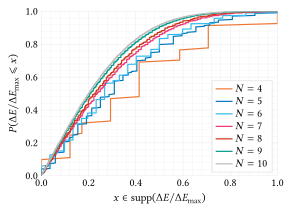

In [36]:
NE = 4
ΔEplot = plot(mid.(ΔEs(NE)), 0:1//3^NE:1-eps(),
    label=latexstring("N = $NE"),
    xlim=(0, 1),
    ylim=(0, 1),
    key=:bottomright,
    xlabel=L"x \in \mathrm{supp}(\Delta E/\Delta E_\text{max})",
    ylabel=L"P(\Delta E/\Delta E_\text{max} \leqslant x)")
for NE in 5:10
    plot!(ΔEplot, mid.(ΔEs(NE)), 0:1//3^NE:1-eps(), label=latexstring("N = $NE"))
end
ΔEplot

As expected, the density approaches a truncated normal distribution.

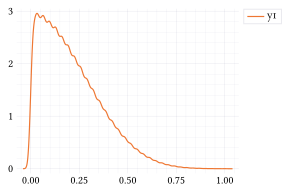

In [37]:
using KernelDensity
ΔE_kde = kde(mid.(ΔEs(12)))
plot(ΔE_kde.x, ΔE_kde.density)

This rigorously shows that the smallest $\Delta E$ is either within the first interval (nonzero) or the second interval (very close to zero).

In [38]:
using DataStructures

LoadError: ArgumentError: Package DataStructures not found in current path:
- Run `import Pkg; Pkg.add("DataStructures")` to install the DataStructures package.


In [39]:
minΔEs = []
Threads.@threads for NE in 2:15 # A parallel fold would be faster
    push!(minΔEs, NE =>
        foldr((x, (m, z)) -> 0 ∈ x ? (m, x ∪ z) : (min(x, m), z),
            ΔEs(NE),
            init=(@interval(Inf), @interval(0))))
end
Dict(minΔEs) |> sort

OrderedCollections.OrderedDict{Int64,Tuple{Interval{Float64},Interval{Float64}}} with 13 entries:
  2  => (1 ± 7.45059e-09, 3.72529e-09 ± 3.7253e-09)
  3  => (0.25 ± 1.9429e-16, 1.249e-16 ± 1.24901e-16)
  4  => (0.12132 ± 1.73028e-09, 1.54307e-09 ± 1.54307e-09)
  5  => (0.0364745 ± 7.63279e-17, 6.00386e-17 ± 6.00387e-17)
  7  => (0.00544257 ± 9.80119e-17, 7.10263e-17 ± 7.10263e-17)
  8  => (0.00355265 ± 7.43639e-10, 7.41006e-10 ± 7.41007e-10)
  9  => (0.00363698 ± 1.6957e-16, 1.90378e-16 ± 1.90379e-16)
  10 => (0.000841145 ± 5.90525e-10, 5.90028e-10 ± 5.90029e-10)
  11 => (0.000302047 ± 2.03668e-16, 2.15277e-16 ± 2.15277e-16)
  12 => (0.000463957 ± 4.90672e-10, 4.90444e-10 ± 4.90444e-10)
  13 => (2.37052e-05 ± 2.3923e-16, 2.60954e-16 ± 2.60955e-16)
  14 => (5.20027e-05 ± 4.19762e-10, 4.1974e-10 ± 4.1974e-10)
  15 => (0.000244098 ± 2.19307e-16, 2.56035e-16 ± 2.56036e-16)

From the plot, we can derive an approximate lower bound for the smallest energy spacing. From the small $N$ plots, it is clear that the energy differences are not uniformly separated. However, the \textsc{cdf} (from sorted indices) is uniformly spaced. Since we have computed $3^N$ energy differences, we may then expect the typical spacing between $\Delta E$ values at $x$ to be $Q'(x) 3^{-N}$, where $Q(x)$ is the limiting differentiable quantile function (inverse \textsc{cdf}). Suppose that for large $N$, $Q'(0) \to k$. From the plots, we estimate that $k > 1/3$. We may then make the following estimates:

In [40]:
Dict(NE => (1/3) * 3.0^-NE for NE in 2:15) |> sort

OrderedCollections.OrderedDict{Int64,Float64} with 14 entries:
  2  => 0.037037
  3  => 0.0123457
  4  => 0.00411523
  5  => 0.00137174
  6  => 0.000457247
  7  => 0.000152416
  8  => 5.08053e-5
  9  => 1.69351e-5
  10 => 5.64503e-6
  11 => 1.88168e-6
  12 => 6.27225e-7
  13 => 2.09075e-7
  14 => 6.96917e-8
  15 => 2.32306e-8

Note that these are all smaller than the actual minimum energy differences, as desired. Now we may estimate the $N$ where the spacing is small enough to cause problems to be around

In [41]:
-log(3, 3*eps()) |> floor |> Int

31

## Construction of superoperators

In [42]:
function addentry!(dict, key, value, isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end

stateE(occ, N=length(occ)) = E0S + 2*sum(n == 1 ? E(m) : 0 for (m, n) in enumerate(occ))

states = fermionstates(f, [0:N...])
energies = Dict{Float64, Vector{Vector{Int64}}}()
for state in states
    addentry!(energies, stateE(state), state, ≈)
end
projectors = Dict(energy => sum(sparse(projector(basisstate(mbb, state))) for state in states)
    for (energy, states) in energies)

ωs = Dict{Float64,Vector{Tuple{Float64,Float64}}}()
for E1 in keys(energies), E2 in keys(energies)
    addentry!(ωs, E2 - E1, (E1, E2), ≈)
end

Now we may compute the superoperators for $\pauli_x^i$.

In [43]:
using ProgressMeter

In [44]:
function Aωs(i)
    A = sxmb(i)
    d = Dict{Float64, typeof(A)}()
    for (ω, Ediffs) in ωs
        Aω = sum(projectors[E1] * A * projectors[E2] for (E1, E2) in Ediffs)
        if Aω != zero(A)
            d[ω] = Aω
        end
    end
    d
end

Aωs (generic function with 1 method)

Since the spectral correlation tensor is already diagonal, the `Aωs(i)` are the Lindblad operators.

## Time evolution

In [45]:
using ProgressMeter

We start the system off in a random state.

In [46]:
ψs = randstate(mbb);

Now we time-evolve the system and look at the expectation values of some reduced operators on the spin chain. We start with just the isolated chain.

In [59]:
function fout(t, ψ)
    next!(progress)
    ψn = normalize(ψ)
    real([
            expect(sxmb(1), ψn)
            ])
end
ts = [0:0.05:20;]
progress = Progress(length(ts))
ts, fouts = timeevolution.schroedinger(ts, ψs, Hmb, fout=fout);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


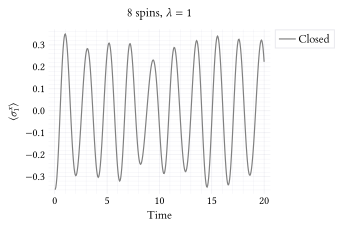

In [74]:
plot(xlabel="Time", ylabel=L"\left\langle\pauli_1^x\right\rangle")
plot!(ts, hcat(fouts...)',
    title = latexstring("$N spins, \$\\lambda = $λ\$"),
    color = :gray,
    label = [
        "Closed"
        ])

In [66]:
savefig("closed.pdf")

Now we consider the open system. 

In [49]:
β, Ω = 100, 1
nB(ω, β) = 1 / (exp(β*ω) - 1)
coupling(ω, Ω) = abs(ω) / (1 + (ω / Ω)^2)
γ(ω, β=β, Ω=Ω) = coupling(ω, Ω)^2 * (nB(ω, β) + 1)
jumpoperators = typeof(first(Aωs(1)).second)[]
γs = Float64[]
progress = Progress(N)
Threads.@threads for i in 1:N
    for (ω, L) in Aωs(i)
        γω = γ(ω)
        if γω > 0
            push!(jumpoperators, L)
            push!(γs, γω)
        end
    end
    next!(progress)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [50]:
progress = Progress(length(ts));
ts, fouts = timeevolution.mcwf(ts, ψs, Hmb, jumpoperators, rates=γs, fout=fout);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


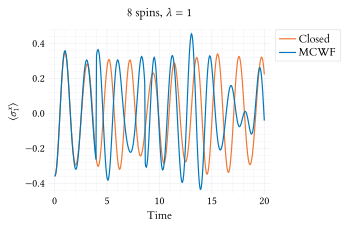

In [51]:
plot!(ts, hcat(fouts...)',
    title = latexstring("$N spins, \$\\lambda = $λ\$"),
    label = [
        "MCWF"
        ])

In [52]:
progress = Progress(length(ts));
ts, fouts = timeevolution.master(ts, ψs, Hmb, jumpoperators, rates=γs, fout=fout);

Progress: 100%|█████████████████████████████████████████| Time: 0:23:39


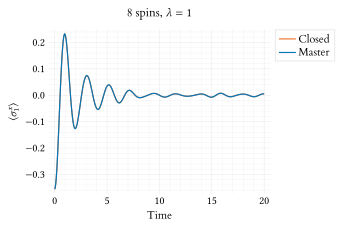

In [55]:
plot!(ts, hcat(fouts...)',
    title = latexstring("$N spins, \$\\lambda = $λ\$"),
    label = [
        "Master"
        ])

In [67]:
rubric = RGB(0.7, 0.05, 0.0);

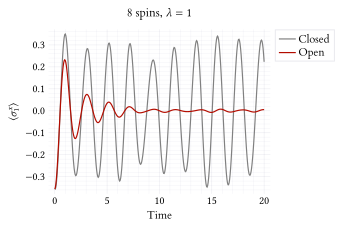

In [71]:
plot!(mts, hcat(mfouts...)',
    title = latexstring("$N spins, \$\\lambda = $λ\$"),
    color = rubric,
    label = [
        "Open"
        ])

In [72]:
savefig("open.pdf")